## EDA on historical financial ratios data

In this notebook, we'll examine the clustering of stocks based on stock financial ratios data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="white")
plt.style.use('default') # fivethirtyeight, ggplot, dark_background, classic,  

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

from kneed import KneeLocator
import warnings
warnings.filterwarnings("ignore")

In [2]:
sp500_comp_profile_df = pd.read_csv('../data/stocks_profile.csv')
print(f'Total count of stocks in profile data: {len(sp500_comp_profile_df.ticker.unique())}')
# sp500_comp_profile_df.head()
stocks_hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
stocks_hist_price_df.date = pd.to_datetime(stocks_hist_price_df.date, format='ISO8601')
print(f'Total count of stocks in hist price data: {len(stocks_hist_price_df.ticker.unique())}')
# stocks_hist_price_df.head()
stocks_hist_ratios_df = pd.read_csv('../data/stocks_hist_ratios.csv')
print(f'Total count of stocks in hist ratios data: {len(stocks_hist_ratios_df.ticker.unique())}') 
# stocks_hist_ratios_df.head()

Total count of stocks in profile data: 503
Total count of stocks in hist price data: 502
Total count of stocks in hist ratios data: 502


### 1. Data cleanup

There are 5 essential categories of financial ratios, namely, liquidity, leverage, efficiency, profitability & market value ratios. We'll consider the following ratios (2 from each category) which are regarded as the most inflential factors for clustering stocks.

1. Liquidity - Quick ratio [(CCE + ST Inv + AR)/Tot CL];    Cash ratio [CCE/Tot CL]

2. Leverage - Debt ratio [Tot Lia/Tot Assets];  Debt Equity [LT Debt/Tot SHE]

3. Efficiency - Asset Turnover [Rev/Tot Assets];    Receivables Turnover [Rev/AR] 

4. Profitability - ROA [NI/Tot Assets];    OPM [Op Inc/Rev]

5. Market Value - EV mul [EV/EBITDA];   Payout Ratio [Div paid/NI]

We'll consider the historical annual measures of these 10 financial ratios starting from fiscal year 2010 to 2019 (10 years), and chose to omit the data for further years. This is done so as to avoid any strong biases that black swan events like Covid-19 pandemic induced market crash and rapid bounce back could have on clustering stocks (leading to poor pair selection later). 

In [3]:
stocks_hist_ratios_df_copy = stocks_hist_ratios_df.copy()

# define the desired target features to train the clustering model
target_ratios = ['Quick ratio', 'Cash ratio', 'Debt ratio', 'Debt equity ratio', 
                 'Asset turnover', 'Receivables turnover', 'Return on assets', 
                 'Operating profit margin', 'Enterprise value multiple', 'Payout ratio']

ratios_df = stocks_hist_ratios_df_copy[['ticker', 'Fiscal Date Ending'] + target_ratios].pivot(
    index='ticker', columns='Fiscal Date Ending', values=target_ratios)

# change the dtypes from object to float
ratios_df = ratios_df.apply(pd.to_numeric, errors='coerce', downcast='float')

ratios_df = ratios_df[[col_tup for col_tup in ratios_df.columns if col_tup[1] < 2020]]
ratios_df.head() 

Quick ratio                                                                Cash ratio                                                                Debt ratio                                                                Debt equity ratio                                                                                     Asset turnover                                                                Receivables turnover                                                                                        Return on assets                                                                Operating profit margin                                                                Enterprise value multiple                                                                                           Payout ratio                                                               
Fiscal Date Ending        2010   2011   2012   2013   2014   2015   2016   2017   2018   2019       2010   2011   2012   2013   2014   2015   2016   2017   2018   2019       2010   2011   2012   2013   2014   2015   2016   2017   2018   2019              2010   2011   2012       2013       2014    2015    2016    2017        2018        2019           2010   2011   2012   2013   2014   2015   2016   2017   2018   2019                 2010       2011       2012    2013       2014       2015       2016    2017    2018    2019             2010   2011   2012   2013   2014   2015   2016   2017   2018   2019                    2010   2011   2012   2013   2014   2015   2016   2017   2018   2019                      2010       2011    2012       2013    2014       2015       2016    2017       2018       2019         2010   2011   2012   2013   2014   2015   2016   2017   2018   2019
ticker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
A                        1.141  2.388  1.730  2.231  2.357  2.673  3.090  2.694  2.582  1.112      0.859  1.920  1.242  1.670  1.779  2.052  2.422  2.120  1.919  0.664      0.666  0.523  0.508  0.505  0.511  0.442  0.456  0.426  0.465  0.498             2.001  1.101  1.033   1.021000   1.044000   0.794   0.838   0.743    0.869000    0.991000          0.561  0.730  0.651  0.635  0.645  0.540  0.539  0.531  0.575  0.546             6.265000   7.692000   7.430000   7.544   7.102000   6.663000   6.659000   6.177   6.332   5.552            0.071  0.112  0.109  0.068  0.047  0.054  0.059  0.081  0.037  0.113                   0.104  0.162  0.163  0.140  0.119  0.129  0.146  0.188  0.189  0.182                    10.238   5.791000   6.585   9.956000  12.780  18.257999  16.552999  20.466  18.796000  21.959999        0.000  0.000  0.090  0.215  0.349  0.332  0.325  0.249  0.604  0.192
AAL                      0.596  0.568  0.539  0.783  0.675  0.564  0.573  0.456  0.357  0.305      0.019  0.033  0.052  0.083  0.074  0.029  0.023  0.020  0.015  0.015      1.157  1.298  1.340  1.065  0.954  0.884  0.926  0.924  1.003  1.002            -7.359 -4.354 -3.944 -16.481001  20.658001   7.592  12.547  12.091 -359.462006 -509.432007          0.884  1.005  1.057  0.633  0.974  0.847  0.784  0.821  0.735  0.763            30.041000  26.584000  22.11300

---

### 2. Pre-processing

##### Imputation of Missing Values

Generally we impute Missing Values or 'NaN' values before proceeding to Machine Learning

Common ways of Imputation:

1. Mean , Mode, median
2. Nearest Neighbours
3. Drop Rows or Columns


First method does not make sense as all the companies have their independent attributes. Although we could fill in the missing values for a company's specific ratio by computing mean measure of the ratio in consideration across time periods. But this method is complicated and we'll table it for now.

Second method does work. What we can do is we can group companies on their sectors and try to impute missing values using nearest neighbours or sector mean/median values for specific ratios. This may come handy, but lets put it aside for now. 

There is one another Brute Force way of imputing and that is finding real values by going through company websites, annual reports, etc. But this method is susceptible to human errors and hence we'll avoid it.

Lets go through the data and do some Exploratory Data Analysis and then choose method that perfectly suits the situation

<Axes: xlabel='None-Fiscal Date Ending', ylabel='None-Fiscal Date Ending'>

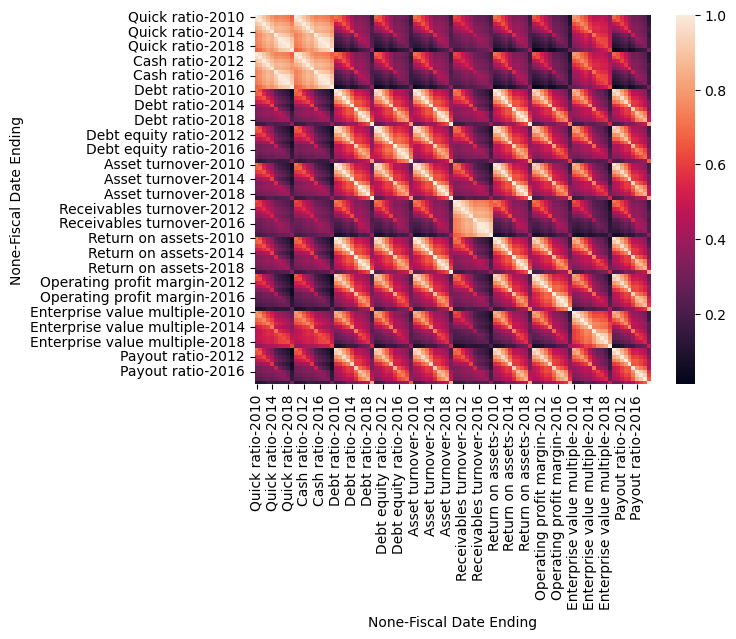

In [4]:
# Nullity corr between variables 
sns.heatmap(ratios_df.isna().corr())

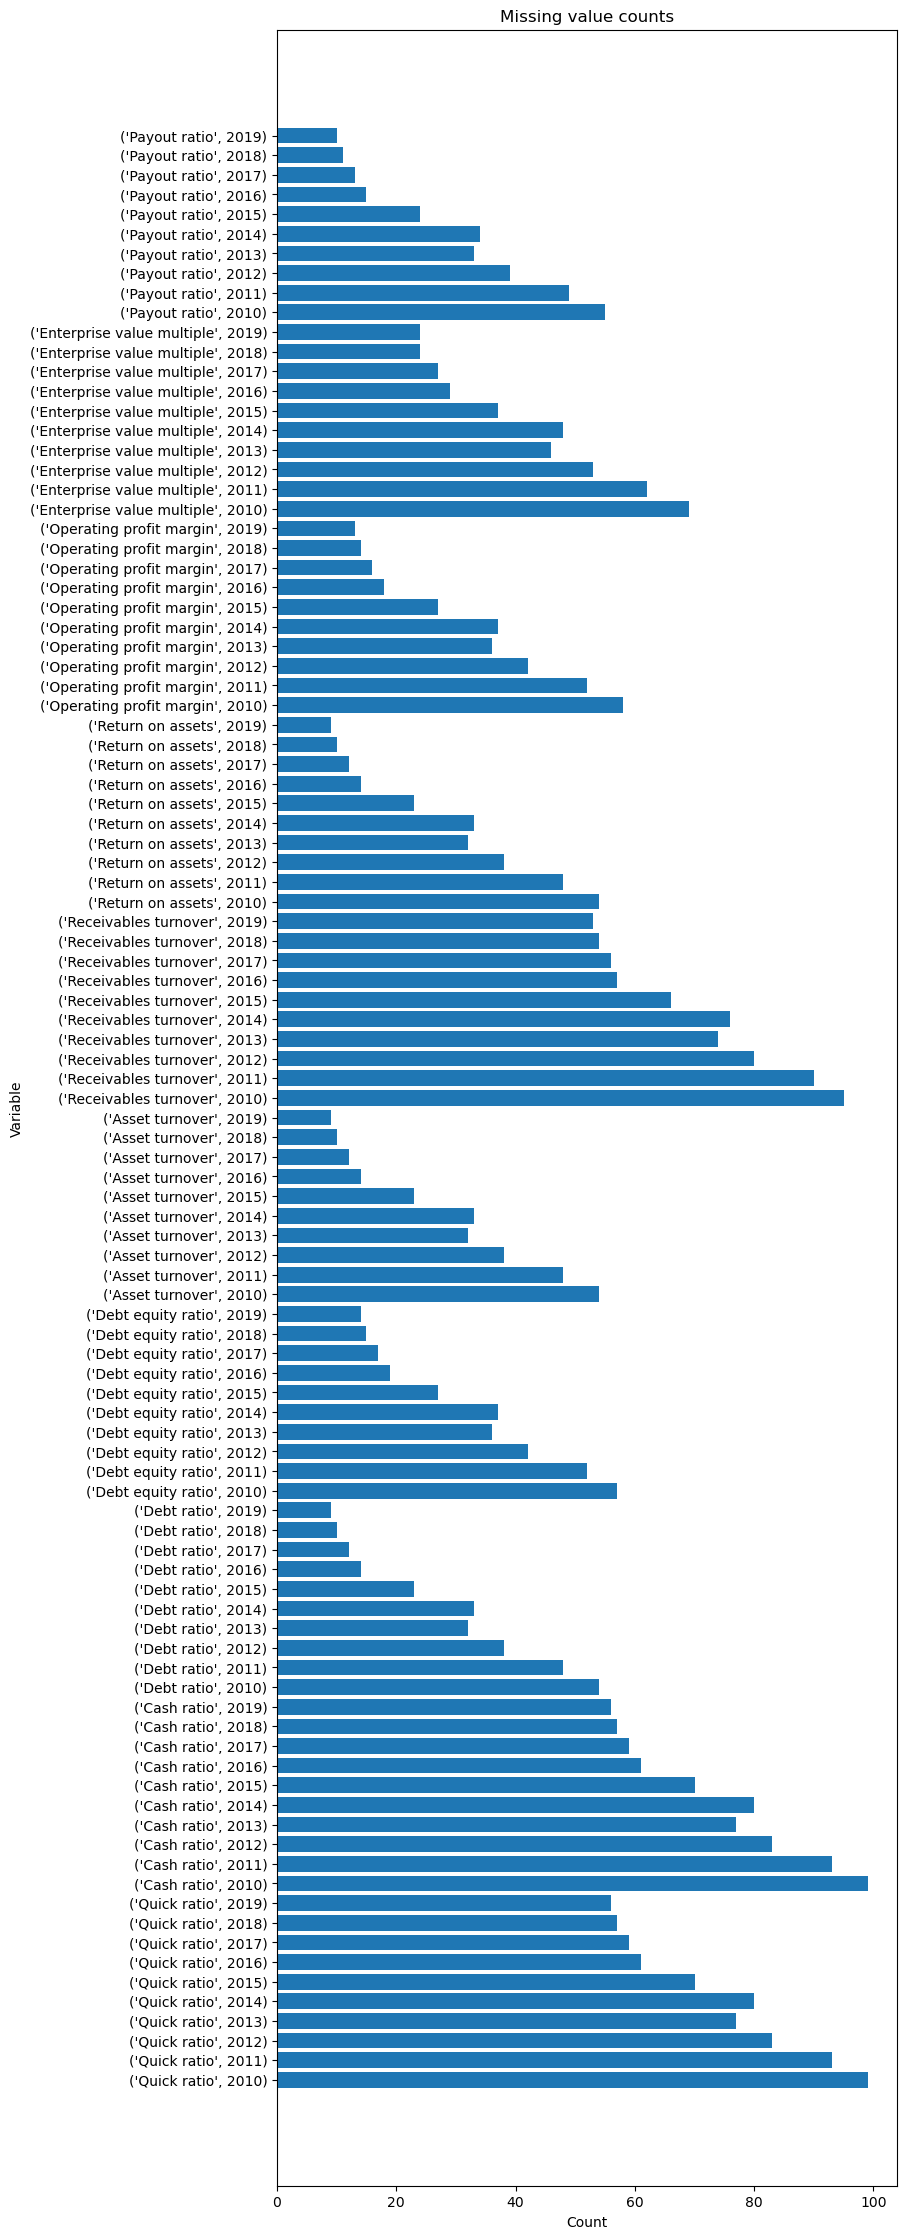

In [5]:
# Plot missing value counts for variables across time periods
plt.figure(figsize=(8, 28))
plt.barh(range(len(ratios_df.columns)), ratios_df.isna().sum())
plt.title('Missing value counts')
plt.xlabel('Count')
plt.ylabel('Variable')
plt.yticks(ticks=range(len(ratios_df.columns)), labels=ratios_df.columns)
plt.show() 

Observations:

1. There are higher proportions of missing values for all the ratios for earlier years of the dataset (2010, 2011, 2012, 2013). This is understandable because some of the current S&P 500 companies were not yet public companies then, and thereby account for larger part of the missing values. We could drop all stocks with missing values, retaining only those with availability to full & accurate data. However, this will reduce our universe of stocks significantly. So instead, we'll proceed with making a conscious choice of considering historical ratio measures from the fiscal year 2015 onwards. This gives us a time horizon of 5 years of historical data. 

2. Based on Nullity corr check, 'Quick ratio' and 'Cash ratio' seem to have near zero corr with all other variables, indicating no interdependence on missing values in other variables. However, both of these along with 'Receivables Turnover' ratio have extremely high corr with their own values across time periods. This means if there's any data missing for these features in certain periods, chances are there are missing values across all other periods as well, and probably point to the same stock.   

In [6]:
# consider only the 5 year ratios data (2015-2019)
ratios_5y_df = ratios_df[[col_tup for col_tup in ratios_df.columns if col_tup[1] >= 2015]]
print(f'Total count of missing values in the train dataset: {ratios_5y_df.isna().sum().sum()}')
ratios_5y_df.dropna(axis=0, how='any', inplace=True)
print(f'\nDrop all the stocks which have any missing values. \nResulting count of stocks: {ratios_5y_df.shape[0]}')


Total count of missing values in the train dataset: 1490

Drop all the stocks which have any missing values. 
Resulting count of stocks: 391


We can observe that nearly 100 stocks were dropped from the initial large sample of 500 stocks. This step was taken so as to have a robust clustering model trained on accurate financial ratios data.

Let's look at the list of stocks which have been dropped out to see if it has any major ones.

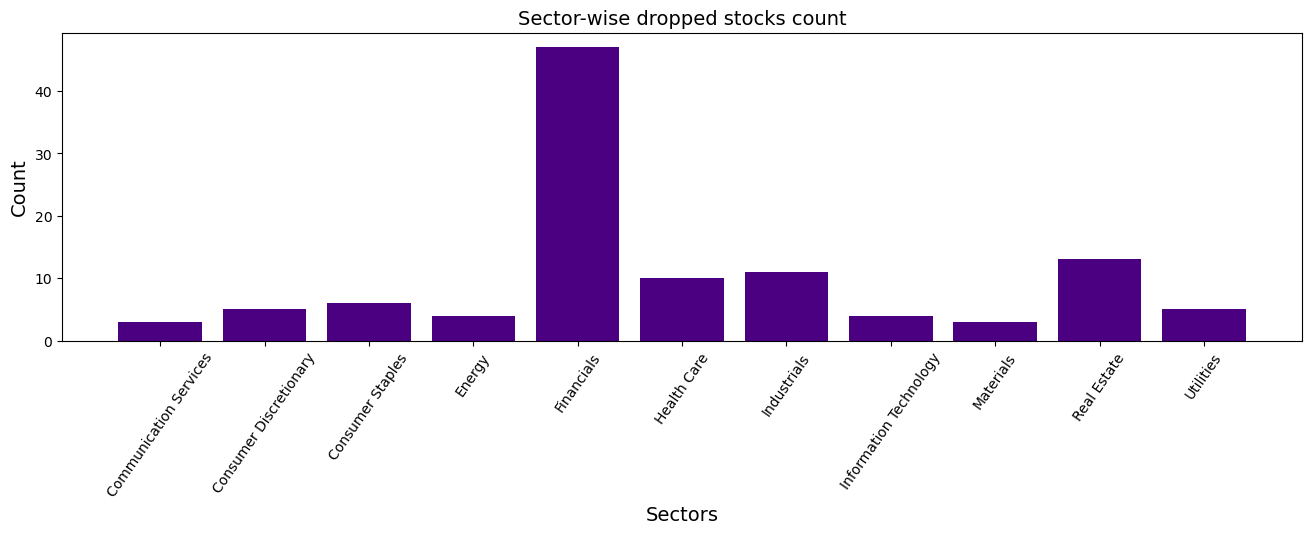

In [7]:
dropped_tikers = [tkr for tkr in ratios_df.index if not ratios_5y_df.index.__contains__(tkr)]
dropped_stocks_df = pd.DataFrame(index=dropped_tikers)
dropped_stocks_df['name'] = [sp500_comp_profile_df[sp500_comp_profile_df['ticker'] == tkr]['company_name'].values[0] for tkr in dropped_tikers]
dropped_stocks_df['sector'] = [sp500_comp_profile_df[sp500_comp_profile_df['ticker'] == tkr]['sector'].values[0] for tkr in dropped_tikers]

# Plot dropped stocks sector wise counts
plt.figure(figsize=(16, 4))
plt.bar(dropped_stocks_df.groupby(['sector']).count().index, dropped_stocks_df.groupby('sector').count()['name'], color='indigo')
plt.title('Sector-wise dropped stocks count', fontsize=14)
plt.xlabel('Sectors', fontsize=14)
plt.xticks(rotation=55)
plt.ylabel('Count', fontsize=14)
plt.show() 

A large number of financial sector stocks were dropped. Is this bad? 

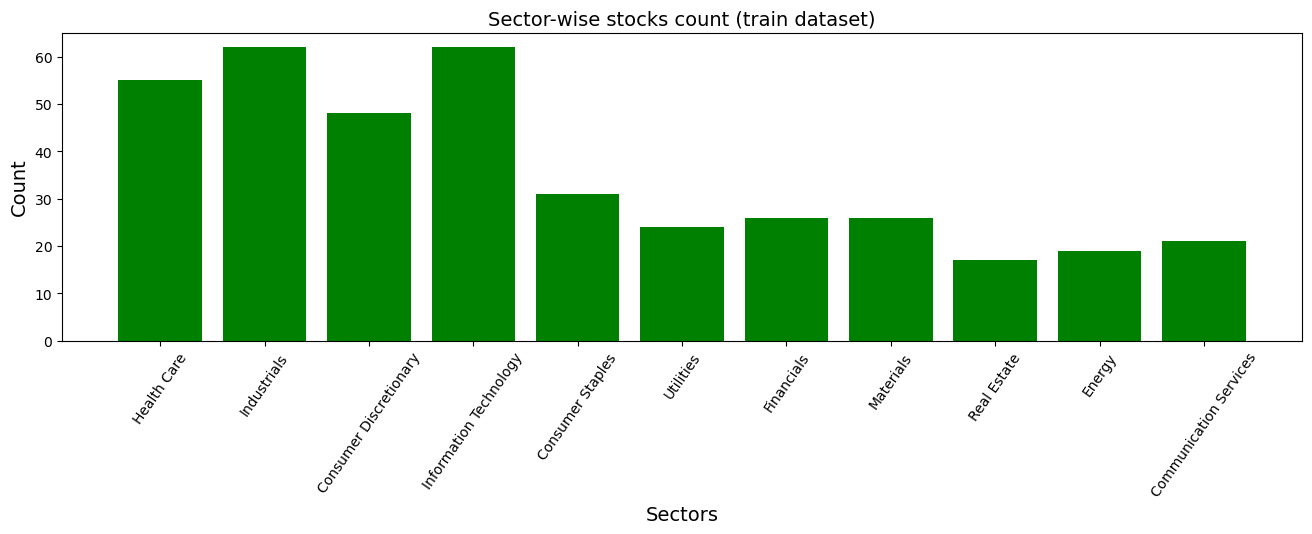

In [8]:
# Plot sector wise counts in the refined target df
sector_counts = Counter([sp500_comp_profile_df[sp500_comp_profile_df.ticker == tkr]['sector'].values[0] for tkr in ratios_5y_df.index])
plt.figure(figsize=(16, 4))
plt.bar(sector_counts.keys(), sector_counts.values(), color='green')
plt.title('Sector-wise stocks count (train dataset)', fontsize=14)
plt.xlabel('Sectors', fontsize=14)
plt.xticks(rotation=55)
plt.ylabel('Count', fontsize=14)
plt.show() 


Seems like we do have a good mix of stocks from all sectors in our cleaned dataset, although Real Estate, Energy & Communication Services sectors have very less representation in the stock universe. For now let's continue with our process

---

### 3. Clustering stocks based on their historical financial ratios data

#### 3.1 PCA for dimensionality reduction

In [9]:
# Standardise & normalise data
def std_normalise_data(data = pd.DataFrame()):
    """
    Standardise & normalise input data
    """
    new_data = StandardScaler().fit_transform(data)
    new_data = Normalizer().fit_transform(new_data) 
    new_df = pd.DataFrame(new_data, index=data.index)

    return new_df

ratios_5y_norm_df = std_normalise_data(ratios_5y_df)
ratios_5y_norm_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.161717,0.229923,0.190814,0.300548,-0.016495,0.242905,0.307992,0.279721,0.467340,0.053777,-0.223038,-0.214116,-0.246563,-0.186345,-0.160147,0.000762,-0.037233,-0.013139,-0.003419,0.009657,-0.106227,-0.096959,-0.095548,-0.083556,-0.080426,-0.061182,-0.067258,-0.068977,-0.065692,-0.069894,-0.015155,-0.019781,0.063205,-0.145045,0.132781,-0.003988,-0.012824,0.043155,0.037651,0.023960,0.059555,-0.007048,0.032667,0.035450,0.029729,0.007790,0.007101,-0.036978,-0.011053,-0.030536
AAL,-0.022530,-0.023360,-0.027324,-0.037387,-0.040732,-0.020376,-0.021235,-0.023087,-0.032661,-0.033891,0.060835,0.068115,0.068037,0.077206,0.078544,0.007130,0.035280,0.028323,-0.652340,-0.723974,0.003666,0.001272,0.005743,-0.003209,0.002463,0.027468,0.024927,0.024690,0.024829,0.025262,0.047977,-0.008475,-0.022256,-0.037772,-0.035867,0.003102,-0.007412,-0.028710,-0.038822,-0.043330,-0.017905,-0.013957,-0.008747,-0.004639,-0.021074,-0.012033,-0.006515,-0.013290,-0.002968,-0.007438
AAP,-0.226225,-0.231952,-0.216347,-0.251014,-0.303836,-0.143722,-0.145251,-0.126140,-0.130412,-0.199816,0.118742,0.023905,-0.056943,-0.044148,0.065245,0.011901,-0.024945,-0.003779,0.003913,0.024866,0.219750,0.219939,0.206904,0.162980,0.075630,0.036671,0.026894,0.044257,0.030301,0.017430,-0.006794,-0.045423,-0.051317,-0.149721,-0.174751,-0.059692,-0.174704,-0.299628,-0.264102,-0.294385,-0.041756,-0.048123,-0.032318,0.001029,-0.075991,-0.084182,-0.055894,-0.111961,-0.021857,-0.060676
AAPL,-0.086738,-0.035773,-0.055640,-0.062866,0.057925,-0.077245,-0.081328,-0.100692,-0.117994,-0.020511,-0.053594,-0.047839,0.015816,0.090713,0.122701,0.004944,-0.029530,0.001963,0.013056,0.026807,0.002068,-0.049705,-0.072904,-0.024203,0.018193,-0.061706,-0.071504,-0.079123,-0.089085,-0.081988,0.376399,0.313063,0.306843,0.354337,0.381340,0.185657,0.269209,0.249582,0.216227,0.192541,-0.081320,-0.063202,-0.020414,-0.003146,-0.049486,-0.023113,-0.003385,-0.040317,-0.017176,-0.029633
ABBV,-0.020054,-0.026129,-0.048415,-0.063066,0.264592,0.014590,-0.014438,-0.010504,-0.020331,0.461376,0.232825,0.227262,0.227000,0.350594,0.322991,0.039877,0.124616,0.100358,-0.055143,-0.054175,-0.096466,-0.102942,-0.097644,-0.059683,-0.099031,-0.049911,-0.051646,-0.048591,-0.043628,-0.041178,0.060268,0.054766,0.024968,0.039582,0.025304,0.114063,0.246080,0.229419,0.031176,0.301039,-0.000206,-0.021224,0.020985,0.019478,-0.043580,0.051546,0.036791,0.048452,-0.004929,0.015715


Method 1 - variance explained by components


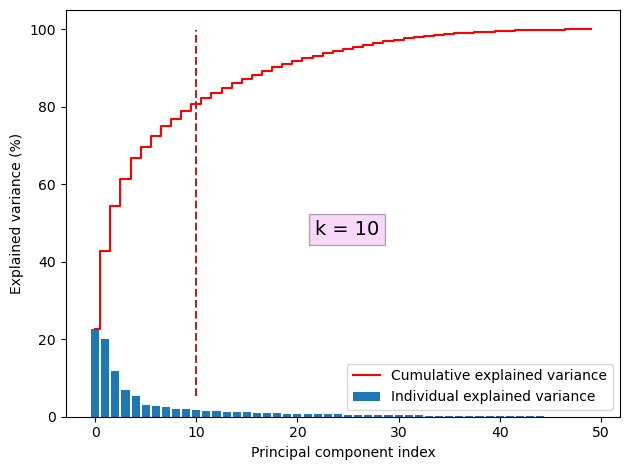

Knee point, explained variance (%) : (10, 80.61452)

---------------------------------------------------------------------

Method 2 - Scree plot


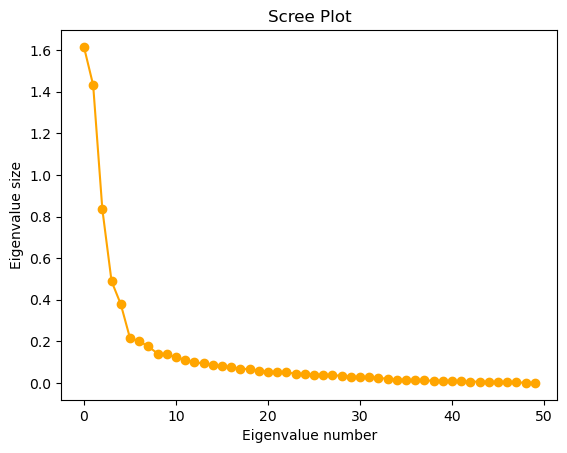

In [10]:
def pca_tuning(data = pd.DataFrame()):
    """
    PCA tuning 
    method 1 - Plot the cummulative explained variance against the count of principal components
    method 2 - Create a Scree plot which gives the visual representation of eigenvalues 
    that define the magnitude of eigenvectors (principal components)
    """
    # Start with basic PCA, keeping all components with no reduction   
    pca_base = PCA(n_components=None)
    pca_base.fit(data)

    # Method 1
    # Fetch variance explained by each individual component & compute the cummulative sum
    print('Method 1 - variance explained by components') 
    exp_var = pca_base.explained_variance_ratio_ * 100
    cum_exp_var = np.cumsum(exp_var)
    knee = KneeLocator(range(0, cum_exp_var.size), cum_exp_var, S=20, curve='concave', direction='increasing', interp_method='interp1d')
    plt.bar(range(0, exp_var.size), exp_var, align='center', label='Individual explained variance')
    plt.step(range(0, cum_exp_var.size), cum_exp_var, where='mid', label='Cumulative explained variance', color='red')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    plt.ylabel('Explained variance (%)')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.figtext(0.5, 0.5, f'k = {knee.knee}', bbox=dict(facecolor='violet', alpha=0.3), fontsize=14)
    plt.tight_layout()
    plt.show()
    print(f'Knee point, explained variance (%) : {knee.knee, cum_exp_var[knee.knee]}')

    # Method 2 - Scree plot
    print('\n---------------------------------------------------------------------\n')
    print('Method 2 - Scree plot')
    plt.plot(pca_base.explained_variance_, marker='o', color='orange')
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue size")
    plt.title("Scree Plot")
    plt.show()

    return pca_base, knee.knee

# Note: PCA needs the input data to be in (n_features, n_samples) format
# for it to function properly and reduce the feature dimensionality
pca_base, knee_point_comps = pca_tuning(ratios_5y_norm_df.T)

##### Method 1:
 The number of bars is equal to the number of variables in the original dataset. In this plot, each bar shows the explained variance percentage of individual components and the step plot shows the cumulative explained variance percentages. By looking at this plot, we can easily decide how many components should be kept and Knee detector points the knee at n_components=10 with explained variance=81%.

##### Method 2:
 Scree Plot which is the visual representation of eigenvalues that define the magnitude of eigenvectors (principal components). We select all the components up to the point where the bend occurs in the Scree Plot. In our case, the scree plot also hints at around n_components=6.

So, we finally decide to go with n_components=10 to fit PCA model on our historical ratios data and obtain the new feature components.

In [11]:
pca_final = PCA(n_components=knee_point_comps) # picked from earlier test
pca_final.fit(ratios_5y_norm_df.T) # Note: we need to input data in the exact required format here for the PCA to work properly

ratios_5y_final_df = pd.DataFrame(pca_final.components_.T, index=ratios_5y_norm_df.index)
print(ratios_5y_final_df.shape)
ratios_5y_final_df.head()

(391, 10)


,0,1,2,3,4,5,6,7,8,9
ticker,,,,,,,,,,
A,-0.082243,-0.018058,-0.054407,0.024493,-0.019357,-0.023006,-0.018196,0.002408,0.024787,-0.081408
AAL,0.015415,0.007377,0.006819,0.018841,0.054781,-0.052260,0.006276,-0.045030,0.013247,0.045004
AAP,0.059743,0.072304,0.010359,-0.066111,-0.012104,0.002397,-0.037338,0.011513,-0.009049,0.014812
AAPL,-0.016552,-0.029741,0.132503,0.042365,-0.005032,-0.024304,-0.015322,0.001033,0.041084,0.009041
ABBV,0.030972,-0.057187,0.013374,0.092824,0.024518,-0.038171,0.008741,0.014157,-0.036321,0.150637


Text(0.5, 1.0, 'Feature space correlation after PCA')

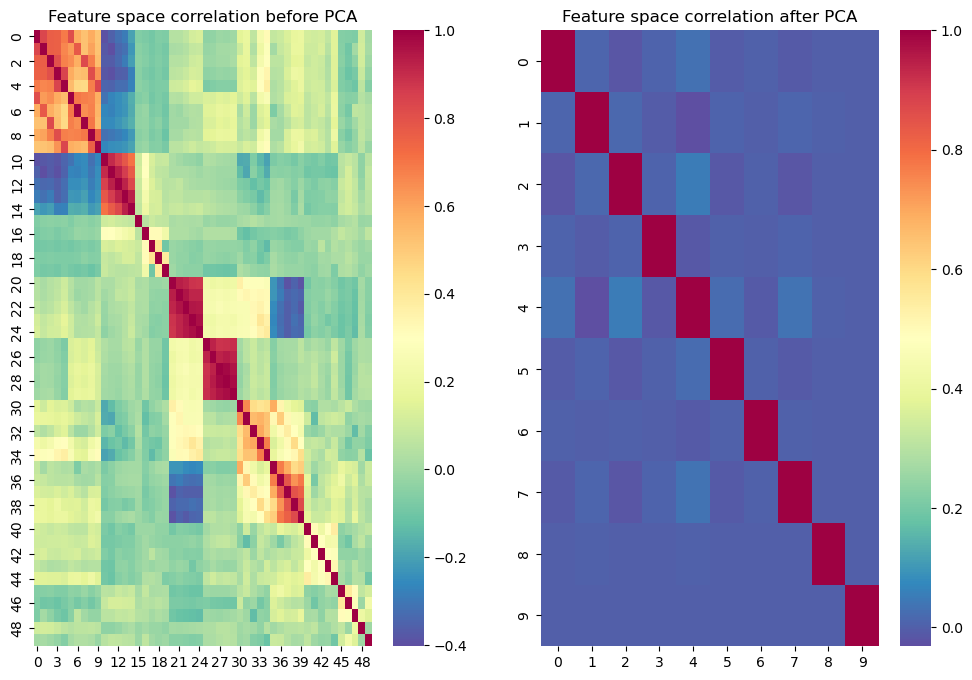

In [12]:
# Lastly, check if new data with reduced dimensions shows any high correlation & compare with data before dimensionality reduction.
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.heatmap(ratios_5y_norm_df.corr(), cmap=cm.Spectral_r)
plt.title('Feature space correlation before PCA')
plt.subplot(1,2,2)
sns.heatmap(ratios_5y_final_df.corr(), cmap=cm.Spectral_r)
plt.title('Feature space correlation after PCA')

As we can see from the above heatmaps, the principal components computed by the PCA have extremely low correlation. Job well done, PCA! 

***

#### 3.2 K-means Clustering

##### Baseline K-means model

Train a K-means with a pre-defined number of clusters - 11, which follows the sector breakdown based on the GICS norms specified by MSCI. S&P 500 uses the same classification rules.   

In [13]:
# Standardise data for clustering 
ratios_5y_final_norm_df = std_normalise_data(ratios_5y_final_df)
ratios_5y_final_norm_df.head()

,0,1,2,3,4,5,6,7,8,9
ticker,,,,,,,,,,
A,-0.607322,-0.090941,-0.437700,0.186687,-0.029173,-0.185155,-0.117132,-0.022190,0.168689,-0.564495
AAL,0.088199,0.104668,-0.009878,0.179193,0.619521,-0.471863,0.063755,-0.428753,0.107812,0.378258
AAP,0.452455,0.638758,0.019827,-0.524319,0.027968,-0.010316,-0.296469,0.048991,-0.078036,0.121236
AAPL,-0.146426,-0.168212,0.853058,0.303316,0.073216,-0.189585,-0.094912,-0.031029,0.274951,0.060694
ABBV,0.130134,-0.261385,0.027231,0.475229,0.208499,-0.208964,0.050036,0.042952,-0.183215,0.750403


In [14]:
def kmeans_baseline(data = pd.DataFrame(), init_method: str='k-means++'):
    """
    Runs a baseline K-means clustering model with k=11.
    """
    kmeans_11 = KMeans(n_clusters = 11, init=init_method, max_iter = 20000, n_init=10, random_state=1500)
    kmeans_11.fit(data)

    # predict the clusters for all stocks
    kmeans_11_clusters = pd.DataFrame(index=data.index, columns=['cluster'])
    kmeans_11_clusters['cluster'] = list(kmeans_11.predict(data))
    kmeans_11_clusters['sector'] = [sp500_comp_profile_df[sp500_comp_profile_df.ticker == tkr]['sector'].values[0] for tkr in kmeans_11_clusters.index]
    kmeans_11_clusters['cluster'].value_counts()

    return kmeans_11_clusters, kmeans_11

km_baseline_1_df, km_baseline_1 = kmeans_baseline(ratios_5y_final_norm_df)
km_baseline_2_df, km_baseline_2 = kmeans_baseline(ratios_5y_final_norm_df, init_method='random')

 'k-means++' selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is "greedy k-means++". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.

'random' choose n_clusters observations (rows) at random from data for the initial centroids.

Observations:

 1. The baseline K-means model (with k=11) results are pretty much similar in both the cases as can be seen above. So the choice of sampling technique is not having a major impact on stock clustering.

KMeans clusters stacked against sectors (kmeans++ initialisation)


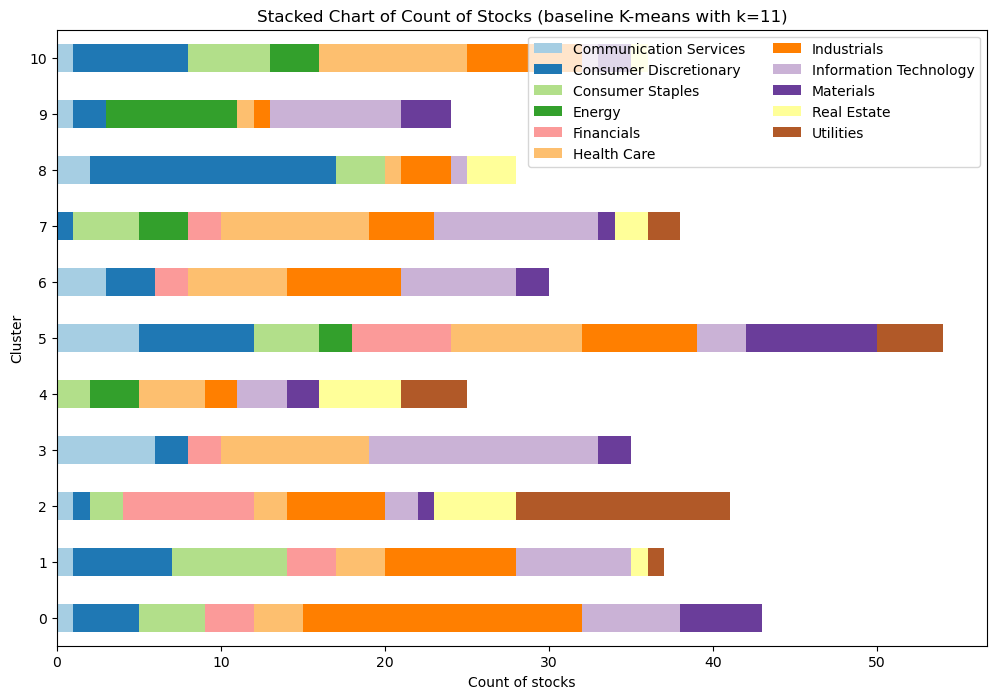

KMeans clusters stacked against sectors (random initialisation)


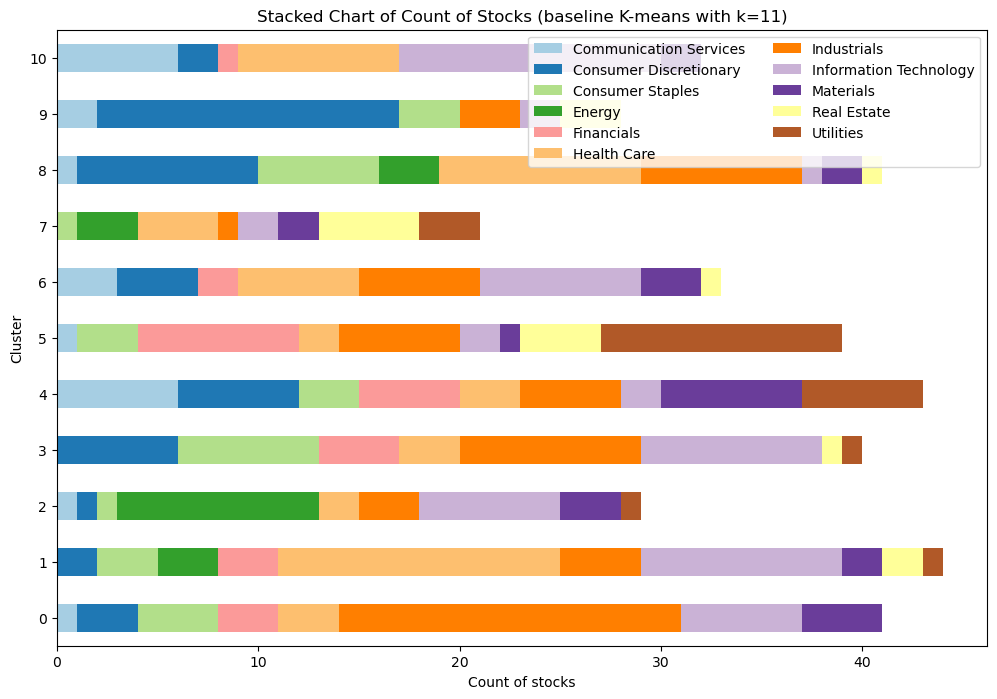

In [15]:
def plot_sector_cluster_stacked_chart(cluster_df=pd.DataFrame()):
    """
    Plot stacked chart of count of stocks across sectors & clusters.
    """
    cross_tab = pd.crosstab(index=cluster_df.cluster, columns=cluster_df.sector)
    cross_tab.plot(kind='barh', stacked=True, colormap=cm.Paired, figsize=(12, 8))
    plt.legend(loc="best", ncol=2)
    plt.ylabel("Cluster")
    plt.xlabel("Count of stocks")
    plt.title("Stacked Chart of Count of Stocks (baseline K-means with k=11)")
    plt.show()


print('KMeans clusters stacked against sectors (kmeans++ initialisation)')
plot_sector_cluster_stacked_chart(km_baseline_1_df)

print('KMeans clusters stacked against sectors (random initialisation)')
plot_sector_cluster_stacked_chart(km_baseline_2_df)

##### Method 1: Elbow method of choosing 'k'

Within-cluster variance is a measure of compactness of the cluster. Lower the value of within cluster variance, higher the compactness of cluster formed.

Sum of within-cluster variance, W, is calculated for clustering analyses done with different values of k. W is a cumulative measure how good the points are clustered in the analysis. Plotting the k values and their corresponding sum of within-cluster variance helps in finding the number of clusters. Initially, error measure (within-cluster variance) decreases with increase in cluster count. After a particular point, say k, Error measure starts flattening. Let's check the value of 'k' in our case

In [16]:
def plot_elbow_curve(data = pd.DataFrame(), k_min: int=2, k_max: int=50, init: str='k-means++'):
    """
    Plot the elbow curve to find optimal 'k' for k-means.
    """
    WSS = []
    k_range = range(k_min, k_max) 
    for k in k_range:
        km = KMeans(n_clusters = k, init=init, max_iter=20000, n_init=10, random_state=1500)
        km.fit(data)
        WSS += [km.inertia_]
   
    plt.plot(k_range, WSS, color='violet', marker='*')
    plt.xlabel('k')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.title(f'Elbow Curve: Plot of K vs WCSS (init={init})')
    knee = KneeLocator(k_range, WSS, curve='convex', direction='decreasing', interp_method='interp1d')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    print(f'Knee point, WCSS : {knee.knee, WSS[knee.knee]}')
    plt.figtext(0.5, 0.5, f'k = {knee.knee}', bbox=dict(facecolor='red', alpha=0.3), fontsize=14)
    plt.show()

    return knee.knee

Knee point, WCSS : (10, 186.886962890625)


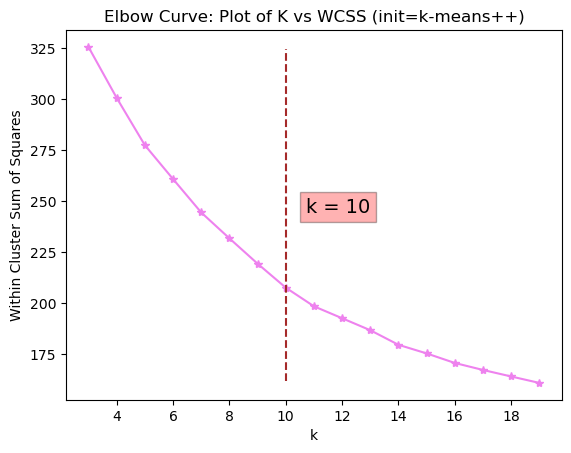

In [17]:
elbow_point_k = plot_elbow_curve(data=ratios_5y_final_norm_df, k_min=3, k_max=20)

The elbow method says that the optimal 'k' value is 10, which is the almost same as our baseline clustering model based on GICS classification standard. Hurrah!

We'll pick k=10 and fit K-means model on our data.

In [18]:
k_final = elbow_point_k # we get this value from Elbow test
km_final = KMeans(n_clusters = k_final, init='k-means++', max_iter=20000, n_init=10, random_state=1500)
km_final = km_final.fit(ratios_5y_final_norm_df)
km_final_clusters_df = pd.DataFrame(index=ratios_5y_final_norm_df.index, columns=['cluster', 'sector'])
km_final_clusters_df['cluster'] = km_final.labels_
km_final_clusters_df['sector'] = [sp500_comp_profile_df[sp500_comp_profile_df.ticker == tkr]['sector'].values[0] for tkr in km_final_clusters_df.index]
km_final_clusters_df.cluster.value_counts()

cluster
0    61
8    43
1    42
5    42
3    41
9    38
4    36
2    33
6    29
7    26
Name: count, dtype: int64

#### Now, on to Model evaluation 

#### 1. Silhouette coefficient

Once clustering is done, how well the clustering has performed can be quantified by a number of metrics. Ideal clustering is characterised by minimal intra cluster distance and maximal inter cluster distance.

There are majorly two types of measures to assess the clustering performance.

1. Extrinsic Measures - which require ground truth labels.
2. Intrinsic Measures - which do not require ground truth labels.

Silhouette Coefficient is an intrinsic measure that measures between-cluster distances against within-cluster distances. A higher ratio signifies the cluster is far away from its nearest cluster and that the cluster is more well-defined.

In [19]:
sil_score_b = silhouette_score(ratios_5y_final_norm_df, labels=km_baseline_2.labels_, random_state=1500)
sil_score = silhouette_score(ratios_5y_final_norm_df, labels=km_final.labels_, random_state=1500)
print(f'\nThe Silhouette Score for K-means baseline model (k=11) fit on preprocessed ratios data : {sil_score_b}')
print(f'\nThe Silhouette Score for our K-means model (k={k_final}) fit on preprocessed ratios data : {sil_score}')


The Silhouette Score for K-means baseline model (k=11) fit on preprocessed ratios data : 0.18288296461105347

The Silhouette Score for our K-means model (k=10) fit on preprocessed ratios data : 0.1726342737674713


The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. Our score of 0.2, although close to zero is still positive. 

#### 2. Calinski-Harabasz Index

If the ground truth labels are not known, the Calinski-Harabasz index - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

In [20]:
cal_hb_score_b = calinski_harabasz_score(ratios_5y_final_norm_df, labels=km_baseline_2.labels_)
cal_hb_score = calinski_harabasz_score(ratios_5y_final_norm_df, labels=km_final.labels_)
print(f'\nThe Calinski Harabasz Score for K-means baseline model (k=11) fit on preprocessed ratios data : {cal_hb_score_b}')
print(f'\nThe Calinski Harabasz Score for our K-means model (k={k_final}) fit on preprocessed ratios data : {cal_hb_score}')


The Calinski Harabasz Score for K-means baseline model (k=11) fit on preprocessed ratios data : 36.94021694303877

The Calinski Harabasz Score for our K-means model (k=10) fit on preprocessed ratios data : 37.300040082630325


In [21]:
def plot_TSNE(data, labels):
    """
    Plot the results of the TSNE algorithm to visualise the 
    cluster densities
    """
    # all stock with its cluster label (including -1)
    clustered_series_all = pd.Series(index=data.index, data=labels)
    # with only actual clusters 
    clustered_series = clustered_series_all[clustered_series_all != -1]

    # to plot multidimension into 2D
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(data)

    plt.figure(1, facecolor='white', figsize=(8,6))
    plt.clf()
    plt.axis('off')

    # clustered
    clst_plot = plt.scatter(
    X_tsne[(clustered_series_all!=-1).values, 0],
    X_tsne[(clustered_series_all!=-1).values, 1],
    s=100, alpha=0.9, c=labels[labels!=-1], cmap=cm.Paired_r, marker='*')
    # unclustered in the background
    plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100, alpha=0.05)

    handles, _ = clst_plot.legend_elements(prop='colors')
    plt.legend(handles, clustered_series.value_counts().index)
    plt.title('T-SNE of all Stocks with Clusters Noted')
    plt.show()

    return clustered_series_all


# show number of stocks in each cluster 
def plot_cluster_counts(labels_df):
    """
    Plot cluster counts histogram bar chart
    """
    plt.figure(figsize=(8,6))
    plt.barh(
    range(len(labels_df[labels_df!=-1].value_counts())), labels_df[labels_df!=-1].value_counts())
    plt.title('Cluster Member Counts')
    plt.xlabel('Stocks in Cluster')
    plt.ylabel('Cluster Number')
    plt.show()

# plot price movements for cluster members
def plot_cluster_members(labels_df):
    """
    Plot the cluster members' log prices
    to observe if they follow a similar path 
    """
    # get the number of stocks in each cluster 
    counts = labels_df[labels_df!=-1].value_counts()

    # let's visualize some clusters
    cluster_vis_list = list(counts[counts>1].index)[::-1]

    sf = stocks_hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')

    # plot a handful of the smallest clusters
    for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]: 
        tickers = list(labels_df[labels_df==clust].index) 
        means = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers].mean())
        data = np.log(sf.loc[:dt.datetime(2018, 12, 31), tickers]).sub(means) 
        data.plot(title='Stock Time Series for Cluster %d' % clust)
        plt.show()


------------------------------------

TSNE plot for the model



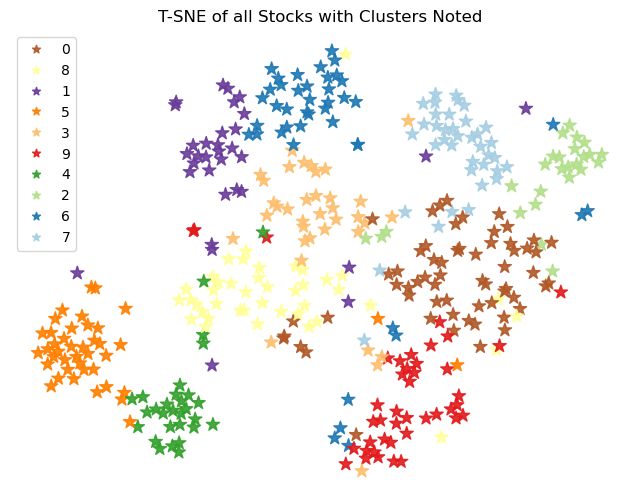


------------------------------------

Cluster counts bar chart



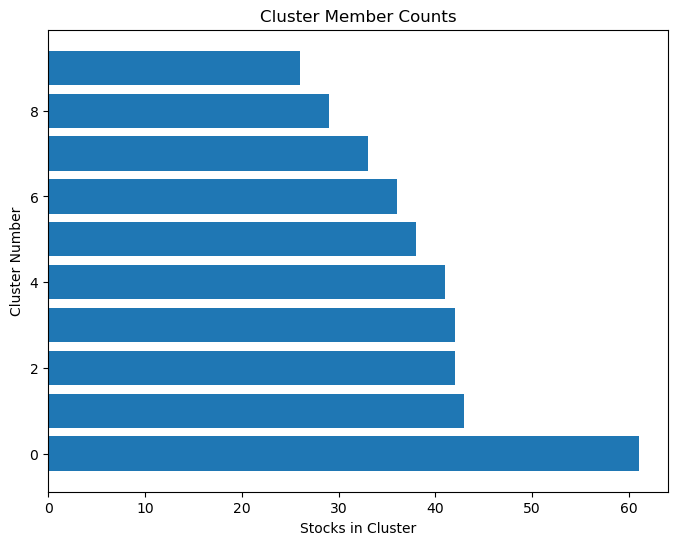


------------------------------------

Cluster member price movements: sample plots of 4 least dense clusters



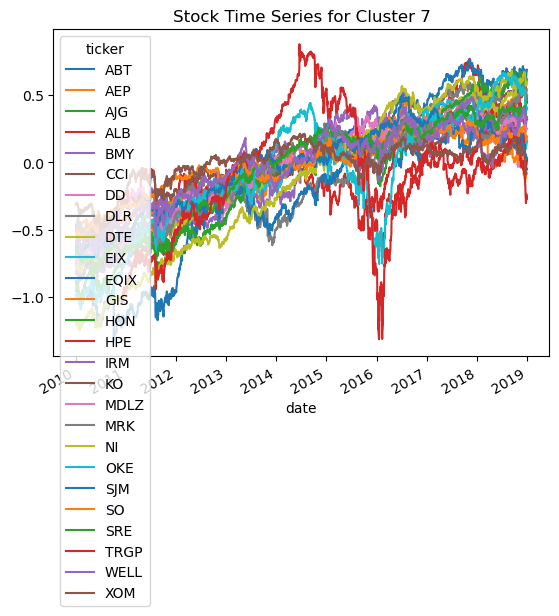

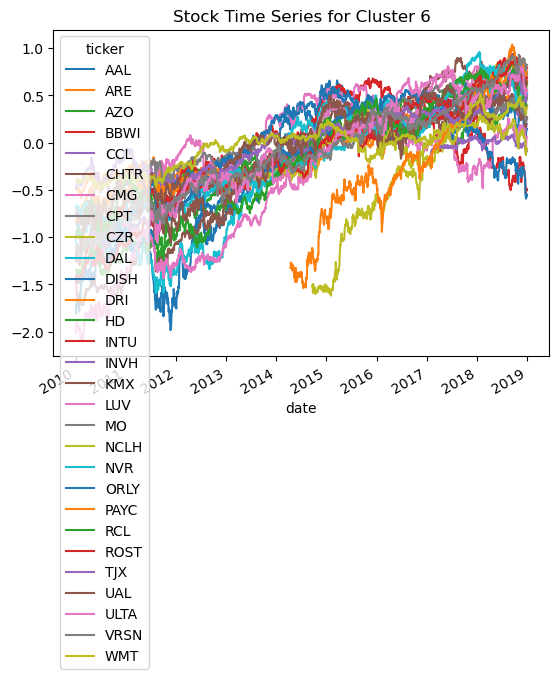

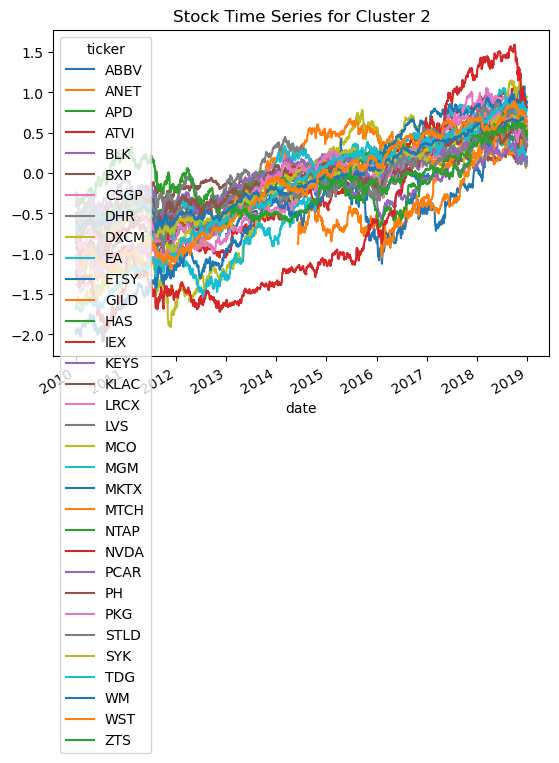

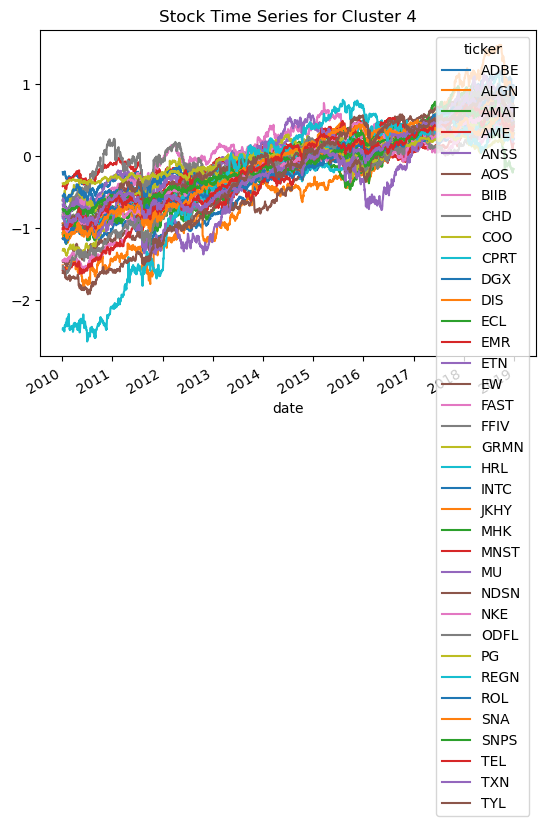

In [22]:
def km_final_plots(data, k: int, labels):
    """
    Plot all charts for the K-means model predictions 
    """
    # TSNE
    print('\n------------------------------------\n')
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('\n------------------------------------\n')
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('\n------------------------------------\n')
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

km_final_plots(ratios_5y_final_norm_df, k_final, labels=km_final.labels_)

------

#### 3.3 OPTICS Clustering

OPTICS stands for Ordering points to identify the clustering structure. It is a density-based unsupervised learning algorithm, which was developed by the same research group that developed DBSCAN.

A single cutoff of distance is applied in DBSCAN to determine whether two data points are close to each other (neighbors) or not. But it may not always be an ideal solution because a “long” distance in one cluster could be a “short” distance in another. In OPTICS each point is assigned a core distance that describes the distance to the MinPtsth closest point, and a reachability distance of another point o from a point p that is either the distance between o and p, or the core distance of p, whichever is bigger.

Running the OPTICS model
----------------------------------------------------------------------------------------------------
max_eps: inf
min_samples: 4
model fit params: {'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 30, 'max_eps': inf, 'memory': None, 'metric': 'minkowski', 'metric_params': None, 'min_cluster_size': None, 'min_samples': 4, 'n_jobs': None, 'p': 2, 'predecessor_correction': True, 'xi': 0.05}

db.cluster_hierarchy_: 
[[  0   7]
 [ 13  16]
 [ 22  25]
 [ 35  40]
 [ 51  55]
 [ 78  81]
 [ 77  98]
 [106 116]
 [139 143]
 [155 161]
 [162 166]
 [162 173]
 [154 175]
 [194 206]
 [218 222]
 [264 277]
 [278 285]
 [334 340]
 [  0 390]]


The Silhouette Score for our OPTICS model fit on preprocessed ratios data : -0.14065054059028625

The Calinski Harabasz Score for our OPTICS model fit on preprocessed ratios data : 7.294646963425592
------------------------------------------------------------------------------------------------------------------------------

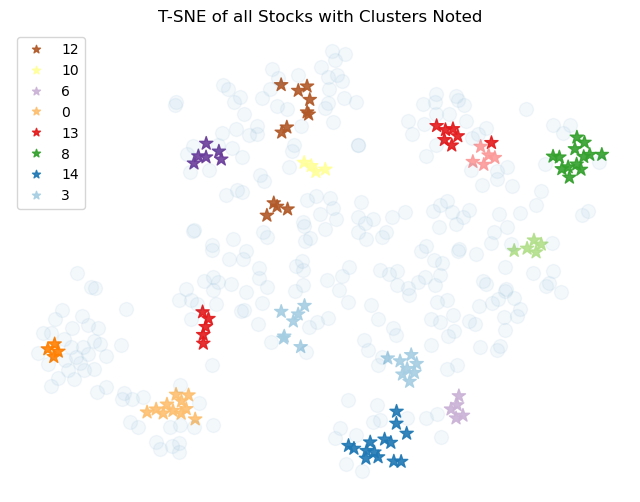

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster counts bar chart



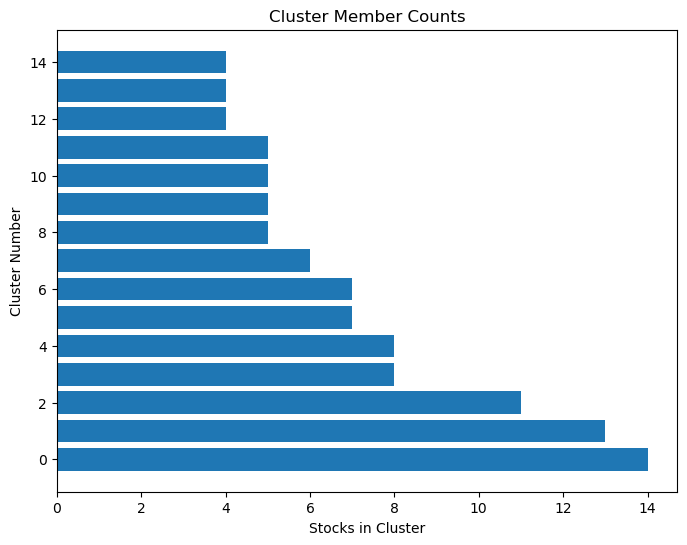

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster member price movements: sample plots of 4 least dense clusters



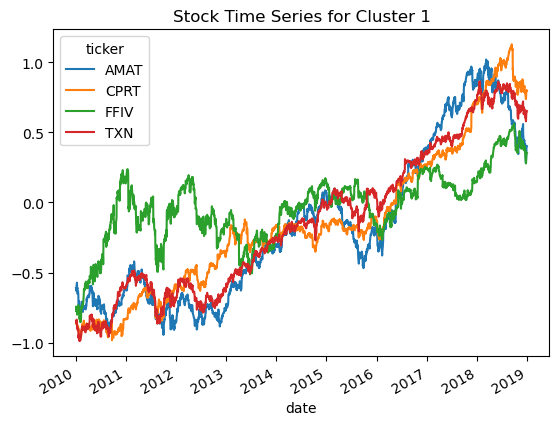

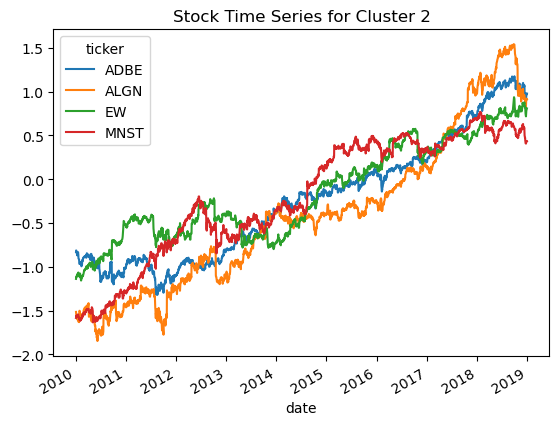

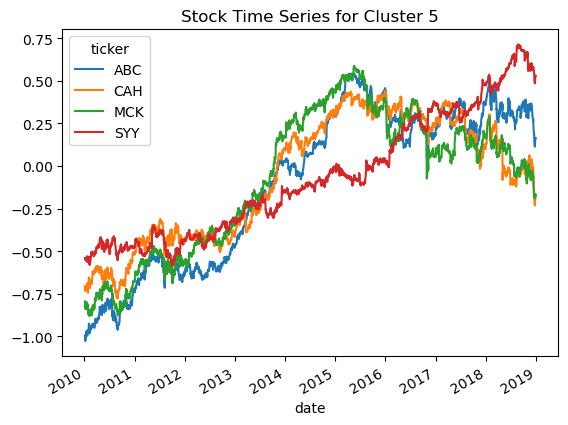

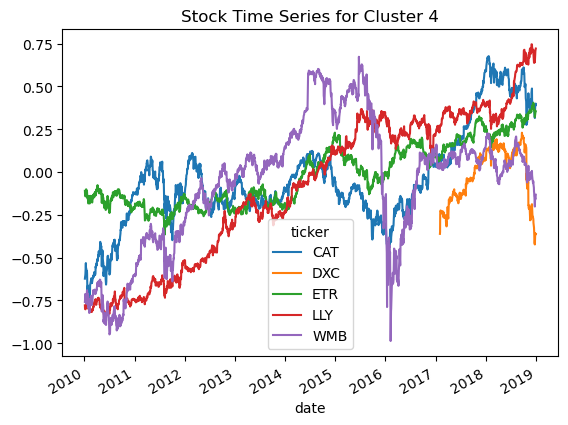

In [23]:
def optics_plots(data, max_eps: float=np.inf, min_samples: int=5):
    """
    Fit OPTICS clustering algorithm over the data;
    Plot all charts for the model predictions 
    """
    print('Running the OPTICS model')
    print('--'*50)
    print(f'max_eps: {max_eps}\nmin_samples: {min_samples}')
    db = OPTICS(max_eps=max_eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    print(f'model fit params: {db.get_params()}\n')
    print(f'db.cluster_hierarchy_: \n{db.cluster_hierarchy_}\n')

    # Compute Silouette score
    sil_score = silhouette_score(data, labels=labels, random_state=1500)
    print(f'\nThe Silhouette Score for our OPTICS model fit on preprocessed ratios data : {sil_score}')

    cal_hb_score = calinski_harabasz_score(data, labels=labels)
    print(f'\nThe Calinski Harabasz Score for our OPTICS model fit on preprocessed ratios data : {cal_hb_score}')

    # TSNE
    print('--'*100)
    print('TSNE plot for the model\n')
    labels_df = plot_TSNE(data, labels)

    # plot cluster count (bar chart)
    print('--'*100)
    print('Cluster counts bar chart\n')
    plot_cluster_counts(labels_df)

    # plot cluster members
    print('--'*100)
    print('Cluster member price movements: sample plots of 4 least dense clusters\n')
    plot_cluster_members(labels_df)

optics_plots(ratios_5y_final_norm_df, min_samples=4)

----

### Ignore this section

#### 3.4 DBSCAN

In [24]:
# def dbscan_tuning(data, eps_min: float=0, eps_max: float=10, eps_step: float=0.1, min_samp: int=3):
#     """
#     This function is used to find the best hyperparameter values for the dbscan algorithm.
#     """
#     fig = plt.figure(figsize=(20, 20))
#     fig.subplots_adjust(hspace=.5, wspace=.2)
#     i = 1
#     print(f'min_samp: {min_samp}')

#     for eps in np.arange(eps_min, eps_max, eps_step):
#         # eps = 1/(11-x)  
#         db = DBSCAN(eps=eps, min_samples=min_samp).fit(data)
#         # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#         # core_samples_mask[db.core_sample_indices_] = True
#         labels = db.labels_
#         label_df = pd.Series(index=data.index, data=labels)
        
#         ax = fig.add_subplot(5, 5, i)
#         # ax.text(x=0.3, y=4.5, s="eps = {}".format(round(eps, 2)), fontsize=16, ha="center")
#         # to plot multidimension into 2D
#         X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1500).fit_transform(data)
#         # sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=["cluster-{}".format(x) for x in labels]) 
#         # plt.figure(1, facecolor='white', figsize=(8,6))
#         # plt.clf()
#         # plt.axis('off')
#         # clustered
#         plt.scatter(
#         X_tsne[(label_df!=-1).values, 0],
#         X_tsne[(label_df!=-1).values, 1],
#         s=100, alpha=0.9, c=label_df[label_df!=-1], cmap=cm.Paired_r, marker='*')
#         # unclustered in the background
#         plt.scatter(
#         X_tsne[(label_df==-1).values, 0],
#         X_tsne[(label_df==-1).values, 1],
#         s=100, alpha=0.05)

#         # handles, _ = clst_plot.legend_elements(prop='colors')
#         # plt.legend(handles, label_df[label_df!=-1].value_counts().index)
#         plt.title(f"eps = {round(eps, 2)}")
        
#         i += 1
#     plt.show()

# dbscan_tuning(data=ratios_5y_df, eps_min=0.5, eps_max=10, eps_step=0.3, min_samp=10)

Method 2:

Since the eps figure is proportional to the expected number of neighbours discovered, we can use the nearest neighbours to reach a fair estimation for eps. Let us compute the nearest neighbours.

In [25]:
# def nn_knee_point_plot(min_samples=3):
#     """
#     Fetch the distance (eps) from the Knee point plot;
#     select the distances of 'n' nearest neighbours, based on our 
#     value requirement for the 'min_samples' param for DBSCAN
#     """
#     nearest_neighbors = NearestNeighbors(n_neighbors=100)
#     neighbors = nearest_neighbors.fit(ratios_5y_final_df)
#     distances, indices = neighbors.kneighbors(ratios_5y_final_df)

#     # here we have considered 3 (default) as the required 'min_samples' value
#     distances = np.sort(distances[:,min_samples], axis=0)
#     i = np.arange(len(distances))
#     knee = KneeLocator(i, distances, S=50, curve='convex', direction='increasing', interp_method='polynomial')

#     plt.figure(figsize=(5, 5))
#     knee.plot_knee()
#     plt.plot(distances)
#     plt.xlabel("Points")
#     plt.ylabel("Distance")
#     print(f'Knee point, distance: {knee.knee, distances[knee.knee]}')
#     plt.show()
#     print('--'*50)

# for i in [5, 10, 20, 30]:
#     print(f'min_samples: {i}')
#     nn_knee_point_plot(i)

---